In [18]:
from tqdm.notebook import tqdm
import numpy as np
import sys
sys.path.append('../')
from partitioning import is_pow_of_two, init_membership_list
from spawn import start_db_background
from structures import Params, NetworkParams
from client_dynamo import client_get, client_put
from parallel_runner import run_parallel
from random import randint

import logging
logger = logging.getLogger('dynamo_node')
logger.setLevel(logging.ERROR)

START_PORT = 2333
CLIENT_ID = 1

def get_start_port(randomize=True):
    return START_PORT + randint(0, params.num_proc-1) * int(randomize)

def get_stats(durations):
    if len(durations) == 0:
        return {}
    durations = np.array(durations) # convert from seconds to ms
    mean = np.mean(durations)
    std = np.std(durations)
    nnth = np.percentile(durations, 99.9)
    return {'mean': mean, 'std': std, '99.9th': nnth}

def generate_plot(durations, label='', clear=True):
    if clear:
        plt.clf()
    fig = sns.distplot(durations, label=label)
    plt.ylabel('Density')
    plt.xlabel('Response Time (in ms)')
    plt.title('Distribution of response times (in ms)')
    plt.legend()
    plt.show()

params = Params({
    'num_proc' : 8,
    'hash_size': 8, # 2^3 = 8 
    'Q' : 16, # 
    'N' : 4,
    'w_timeout': 2,
    'r_timeout': 2,
    'R': 1,
    'W': 3,
    'gossip': True,
    'update_failure_on_rpcs': False,
    'gossip_update_time': (0.5, 0.8)
})

In [19]:
def store_keys(params):
    for key in tqdm(range(2**params.hash_size)):
        client_put(get_start_port(), CLIENT_ID, key=key, val=str(key))

In [20]:
store_keys(params)

In [21]:
get_durations = np.array([])

In [22]:
def run_multiple_get(total, num_requests, get_durations, max_key=2**params.hash_size-1):
    for i in tqdm(range(total // num_requests)):
        requests = [client_get]*num_requests
        requests_params = [{'port': get_start_port(), 'client_id': CLIENT_ID, 'key': randint(0, max_key)} for _ in range(num_requests)]
        get_durations = np.concatenate((get_durations, run_parallel(requests, requests_params, start_port=START_PORT)[0]))
    return get_durations

def run_multiple_put(total, num_requests, put_durations, max_key=2**params.hash_size-1):
    for i in tqdm(range(total // num_requests)):
        requests = [client_put]*num_requests
        requests_params = [{'port': get_start_port(), 'client_id': CLIENT_ID, 'key': randint(0, max_key), 'val': str(randint(0, 2**params.hash_size-1))} for _ in range(num_requests)]
        put_durations = np.concatenate((put_durations, run_parallel(requests, requests_params, start_port=START_PORT)[0]))
    return put_durations

## With uniformly random load

In [23]:
get_durations = run_multiple_get(1000, 10, get_durations)

In [24]:
get_durations.shape

(1000,)

In [25]:
get_durations *= 1000

In [26]:
get_durations.mean(), get_durations.std()

(34.041444301605225, 9.834500553290738)

In [27]:
stats_get = get_stats(get_durations)

In [28]:
for k,v in stats_get.items():
    print(f'{k}: {v:.2f} ms')

mean: 34.04 ms
std: 9.83 ms
99.9th: 125.48 ms


In [29]:
put_durations = np.array([])

In [30]:
put_durations = run_multiple_put(1000, 10, put_durations)

In [31]:
put_durations.shape

(1000,)

In [32]:
put_durations *= 1000

In [33]:
put_stats = get_stats(put_durations)

In [34]:
for k,v in put_stats.items():
    print(f'{k}: {v:.2f} ms')

mean: 22.34 ms
std: 13.27 ms
99.9th: 122.58 ms


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

sns.set(font_scale = 2)
legend_size = 20

/opt/miniconda3/envs/dynamo/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dynamo/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


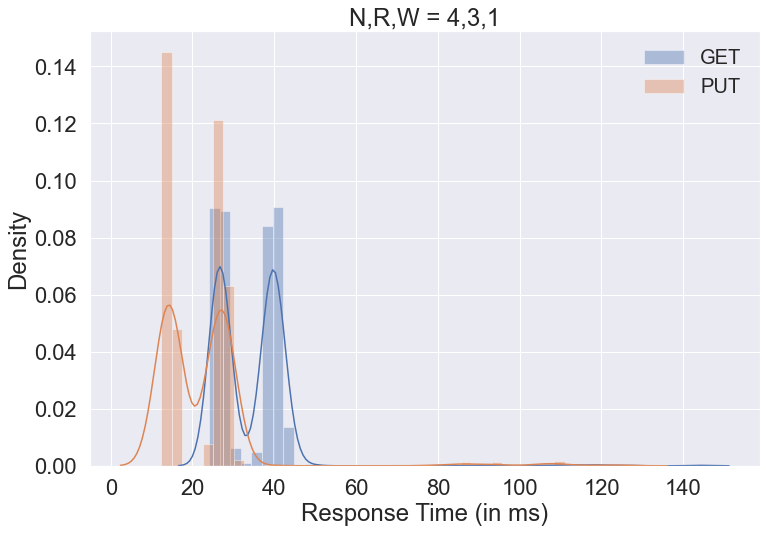

In [36]:
plt.figure(figsize=(12,8))

sns.distplot(get_durations, label='GET')
sns.distplot(put_durations, label='PUT')
plt.ylabel('Density')
plt.xlabel('Response Time (in ms)')
plt.title('N,R,W = 4,3,1')
plt.legend(prop={'size': legend_size})
plt.show()

## With load on selected keys

In [37]:
get_durations2 = np.array([])
get_durations2 = run_multiple_get(1000, 10, get_durations2, 1) * 1000

In [38]:
get_durations2.shape

(1000,)

In [39]:
stats_get2 = get_stats(get_durations2)

for k,v in stats_get2.items():
    print(f'{k}: {v:.2f} ms')

mean: 36.90 ms
std: 19.80 ms
99.9th: 188.51 ms


In [40]:
put_durations2 = np.array([])
put_durations2 = run_multiple_put(1000, 10, put_durations2, 1) * 1000

In [41]:
put_durations2.shape

(1000,)

In [42]:
put_stats2 = get_stats(put_durations2)

for k,v in put_stats2.items():
    print(f'{k}: {v:.2f} ms')

mean: 22.14 ms
std: 12.79 ms
99.9th: 109.50 ms


/opt/miniconda3/envs/dynamo/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dynamo/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


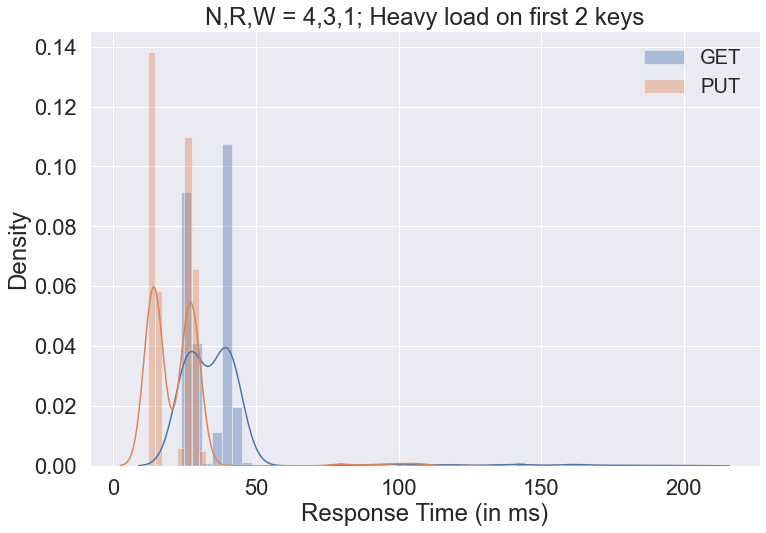

In [43]:
plt.figure(figsize=(12,8))

sns.distplot(get_durations2, label='GET')
sns.distplot(put_durations2, label='PUT')
plt.ylabel('Density')
plt.xlabel('Response Time (in ms)')
plt.title('N,R,W = 4,3,1; Heavy load on first 2 keys')
plt.legend(prop={'size': legend_size})
plt.show()